In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import os
import numpy as np, scipy, sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
import os, glob

DATA_DIR = r"C:\Users\DELL\Downloads\archive"
print("Contents:", os.listdir(DATA_DIR))


Contents: ['archive.rar', 'Brain Tumor', 'Brain Tumor.csv', 'bt_dataset_t3.csv', 'Image26.jpg', 'Image3.jpg', 'Image32.jpg', 'Image4.jpg', 'Image58.jpg', 'Image59.jpg', 'Image60.jpg', 'Image69.jpg', 'Image88.jpg', 'Image89.jpg', 'Image93.jpg', 'Image94.jpg']


In [3]:
CSV_PATH = f"{DATA_DIR}\\Brain Tumor.csv"
IMG_DIR  = f"{DATA_DIR}\\Brain Tumor\\Brain Tumor"

print("CSV:", CSV_PATH)
print("Images dir:", IMG_DIR)
print("Number of images:", len(os.listdir(IMG_DIR)))

CSV: C:\Users\DELL\Downloads\archive\Brain Tumor.csv
Images dir: C:\Users\DELL\Downloads\archive\Brain Tumor\Brain Tumor
Number of images: 3762


In [4]:
df = pd.read_csv(CSV_PATH)
print("Columns:", df.columns.tolist())
display(df.head())

Columns: ['Image', 'Class', 'Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness']


,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [5]:
df["filepath"] = df["Image"].astype(str).apply(
    lambda x: os.path.join(IMG_DIR, x + ".jpg")
)

df["exists"] = df["filepath"].apply(os.path.exists)

print("Valid rows:", df["exists"].sum())
print("Missing rows:", (~df["exists"]).sum())

df = df[df["exists"]].reset_index(drop=True)

Valid rows: 3762
Missing rows: 0


In [6]:
df = pd.read_csv(CSV_PATH)
df["filepath"] = df["Image"].astype(str).apply(
    lambda x: os.path.join(IMG_DIR, x + ".jpg")
)

df["exists"] = df["filepath"].apply(os.path.exists)

print("Valid rows:", df["exists"].sum())
print("Missing rows:", (~df["exists"]).sum())

df = df[df["exists"]].reset_index(drop=True)

Valid rows: 3762
Missing rows: 0


In [7]:
! conda activate base
! conda install -y "numpy<2" "scipy<1.12" "scikit-learn<1.5"

Retrieving notices: done
Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



In [8]:
df["label_str"] = df["Class"].astype(str)

print("Unique labels:", df["label_str"].unique())

Unique labels: ['0' '1']


In [9]:
! conda create -n brain_mri_clean python=3.10 -y
! conda activate brain_mri_clean
! python -V

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\DELL\anaconda3\envs\brain_mri_clean

  added / updated specs:
    - python=3.10


The following NEW packages will be INSTALLED:

  bzip2              pkgs/main/win-64::bzip2-1.0.8-h2bbff1b_6 
  ca-certificates    pkgs/main/win-64::ca-certificates-2025.12.2-haa95532_0 
  expat              pkgs/main/win-64::expat-2.7.3-h885b0b7_4 
  libexpat           pkgs/main/win-64::libexpat-2.7.3-h885b0b7_4 
  libffi             pkgs/main/win-64::libffi-3.4.4-hd77b12b_1 
  libzlib            pkgs/main/win-64::libzlib-1.3.1-h02ab6af_0 
  openssl            pkgs/main/win-64::openssl-3.0.18-h543e019_0 
  pip                pkgs/main/noarch::pip-25.3-pyhc872135_0 
  python             pkgs/main/win-64::python-3.10.19-h981015d_0 
  setuptools         pkgs/main/win-64::setuptools-80.9.0-py310haa95532_0 
  sqlite             pkgs/main/win-64::sqlite-3.51.0-hda9a48d_0 
  tk   

In [10]:
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sklearn.__version__)

numpy: 1.26.4
scipy: 1.11.4
sklearn: 1.4.2


In [11]:
IMG_SIZE = (224, 224)

base = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False 

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = tf.keras.applications.densenet.preprocess_input(inputs)  # important
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [12]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df["label_str"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label_str"]
)

print("Train / Val / Test:", len(train_df), len(val_df), len(test_df))


Train / Val / Test: 2633 564 565


In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label_str",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label_str",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label_str",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_data.class_indices)


Found 2633 validated image filenames belonging to 2 classes.
Found 564 validated image filenames belonging to 2 classes.
Found 565 validated image filenames belonging to 2 classes.
Class indices: {'0': 0, '1': 1}


In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, mode="max", min_lr=1e-6)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.4590 - auc: 0.4757 - loss: 0.7504 - val_accuracy: 0.5514 - val_auc: 0.5210 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.5218 - auc: 0.5147 - loss: 0.7110 - val_accuracy: 0.5532 - val_auc: 0.6187 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.5161 - auc: 0.5082 - loss: 0.7105 - val_accuracy: 0.5532 - val_auc: 0.6842 - val_loss: 0.6753 - learning_rate: 1.0000e-04
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.5383 - auc: 0.5335 - loss: 0.6974 - val_accuracy: 0.5532 - val_auc: 0.7329 - val_loss: 0.6700 - learning_rate: 1.0000e-04
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.5361 - auc: 0.5174 - loss: 0.7002 - val_accuracy: 0.5567 - val_auc: 0.7649 - val_loss: 0.6649 - learning_rate: 1.0000e-04
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0

{'loss': 0.613715410232544, 'compile_metrics': 0.7362831830978394}


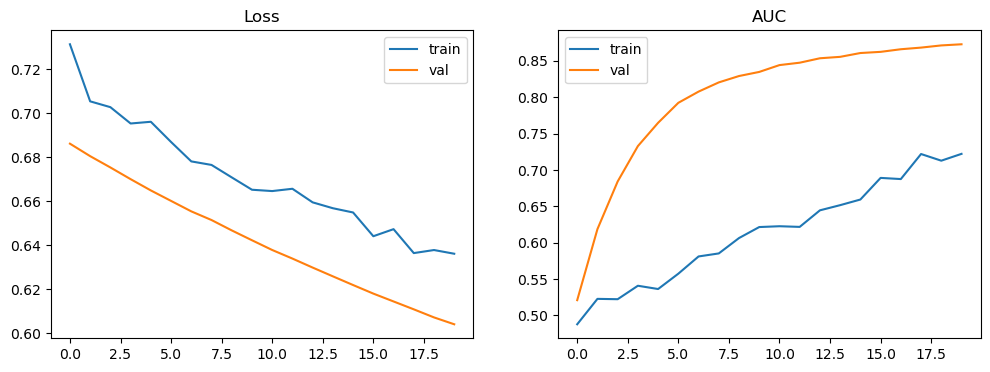

Classification report:
               precision    recall  f1-score   support

           0     0.6856    0.9647    0.8016       312
           1     0.9127    0.4545    0.6069       253

    accuracy                         0.7363       565
   macro avg     0.7992    0.7096    0.7042       565
weighted avg     0.7873    0.7363    0.7144       565

Confusion matrix:
 [[301  11]
 [138 115]]


In [15]:
test_metrics = model.evaluate(test_data, verbose=0)
print(dict(zip(model.metrics_names, test_metrics)))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["auc"], label="train")
plt.plot(history.history["val_auc"], label="val")
plt.title("AUC")
plt.legend()
plt.show()

y_prob = model.predict(test_data, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

y_true = np.array(test_data.labels).astype(int)
print("Classification report:\n", classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


In [16]:
print("Train:", train_df["label_str"].value_counts())
print("Val:", val_df["label_str"].value_counts())
print("Test:", test_df["label_str"].value_counts())

Train: label_str
0    1455
1    1178
Name: count, dtype: int64
Val: label_str
0    312
1    252
Name: count, dtype: int64
Test: label_str
0    312
1    253
Name: count, dtype: int64


In [17]:
def find_last_conv_in_submodel(submodel: tf.keras.Model) -> str:
    for layer in reversed(submodel.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("No Conv2D/DepthwiseConv2D found in submodel.")


In [18]:
LAST_CONV = "conv5_block16_2_conv"  

def gradcam_binary_densenet_connected(base_model, head_layers, img_batch, last_conv_layer_name=LAST_CONV):
    """
    base_model: DenseNet121(include_top=False)
    head_layers: dict contenant les couches de tête (gap, dropout, dense)
    img_batch: (1,224,224,3) en [0,1]
    """
    conv_layer = base_model.get_layer(last_conv_layer_name)

    backbone_multi = tf.keras.Model(
        inputs=base_model.input,
        outputs=[conv_layer.output, base_model.output]
    )

    img_batch = tf.convert_to_tensor(img_batch)

    x = tf.keras.applications.densenet.preprocess_input(img_batch)

    with tf.GradientTape() as tape:
        conv_out, feats = backbone_multi(x, training=False)   

        z = head_layers["gap"](feats)
        z = head_layers["dropout"](z, training=False)
        pred = head_layers["dense"](z)                        
        prob = pred[:, 0]
        class_score = prob

    grads = tape.gradient(class_score, conv_out)             

    conv_out = conv_out[0] 
    grads = grads[0]       

    grad_map = tf.reduce_mean(tf.abs(grads), axis=-1)
    grad_map = grad_map / (tf.reduce_max(grad_map) + 1e-8)
    grad_map = grad_map.numpy()

    # Grad-CAM
    weights = tf.reduce_mean(grads, axis=(0, 1))            
    cam = tf.reduce_sum(conv_out * weights, axis=-1)        
    cam = tf.nn.relu(cam)
    heatmap = cam / (tf.reduce_max(cam) + 1e-8)

    # Resize
    H, W = img_batch.shape[1], img_batch.shape[2]
    heatmap_resized = tf.image.resize(heatmap[..., None], (H, W))
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()

    # Overlay
    img_rgb = (img_batch[0].numpy() * 255).astype(np.uint8)
    colored = (plt.get_cmap("jet")(heatmap_resized)[:, :, :3] * 255).astype(np.uint8)
    alpha = 0.35
    overlay = (img_rgb * (1 - alpha) + colored * alpha).astype(np.uint8)

    return float(prob.numpy()[0]), grad_map, heatmap_resized, overlay


In [19]:
print(base.name)
print(find_last_conv_in_submodel(base))
print(model.inputs, model.outputs)

densenet121
conv5_block16_2_conv
[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_427>] [<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_434>]


In [20]:
gap_layer = None
drop_layer = None
dense_layer = None

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        gap_layer = layer
    if isinstance(layer, tf.keras.layers.Dropout):
        drop_layer = layer
    if isinstance(layer, tf.keras.layers.Dense) and layer.units == 1:
        dense_layer = layer

head_layers = {"gap": gap_layer, "dropout": drop_layer, "dense": dense_layer}
print(head_layers)

{'gap': <GlobalAveragePooling2D name=global_average_pooling2d, built=True>, 'dropout': <Dropout name=dropout, built=True>, 'dense': <Dense name=dense, built=True>}


True label: 1 | Pred prob(tumor): 0.48220962285995483


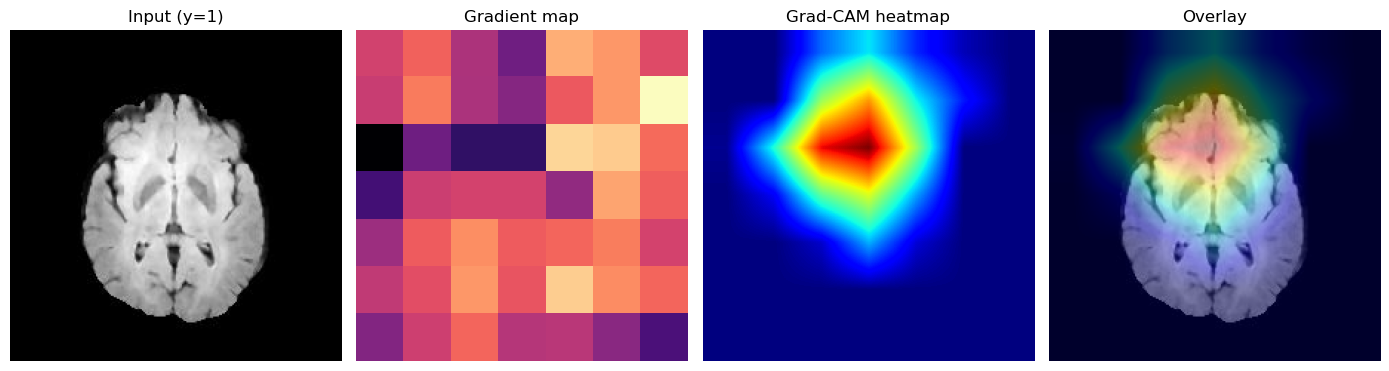

In [21]:
x_batch, y_batch = next(test_data)
img = x_batch[0:1]
true_label = int(y_batch[0])

prob, grad_map, heatmap, overlay = gradcam_binary_densenet_connected(base, head_layers, img)

print("True label:", true_label, "| Pred prob(tumor):", prob)

plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.title(f"Input (y={true_label})"); plt.imshow(img[0]); plt.axis("off")
plt.subplot(1,4,2); plt.title("Gradient map"); plt.imshow(grad_map, cmap="magma"); plt.axis("off")
plt.subplot(1,4,3); plt.title("Grad-CAM heatmap"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()


True label: 0 | Pred prob(tumor): 0.38580435514450073


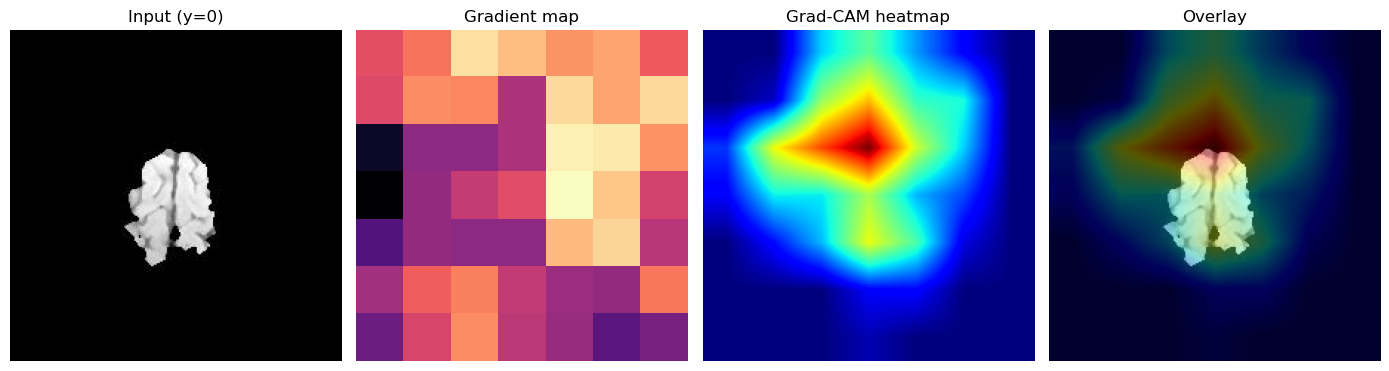

In [48]:
x_batch, y_batch = next(test_data)
img = x_batch[0:1]
true_label = int(y_batch[0])

prob, grad_map, heatmap, overlay = gradcam_binary_densenet_connected(base, head_layers, img)

print("True label:", true_label, "| Pred prob(tumor):", prob)

plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.title(f"Input (y={true_label})"); plt.imshow(img[0]); plt.axis("off")
plt.subplot(1,4,2); plt.title("Gradient map"); plt.imshow(grad_map, cmap="magma"); plt.axis("off")
plt.subplot(1,4,3); plt.title("Grad-CAM heatmap"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()

True label: 1 | Pred prob(tumor): 0.5405691266059875


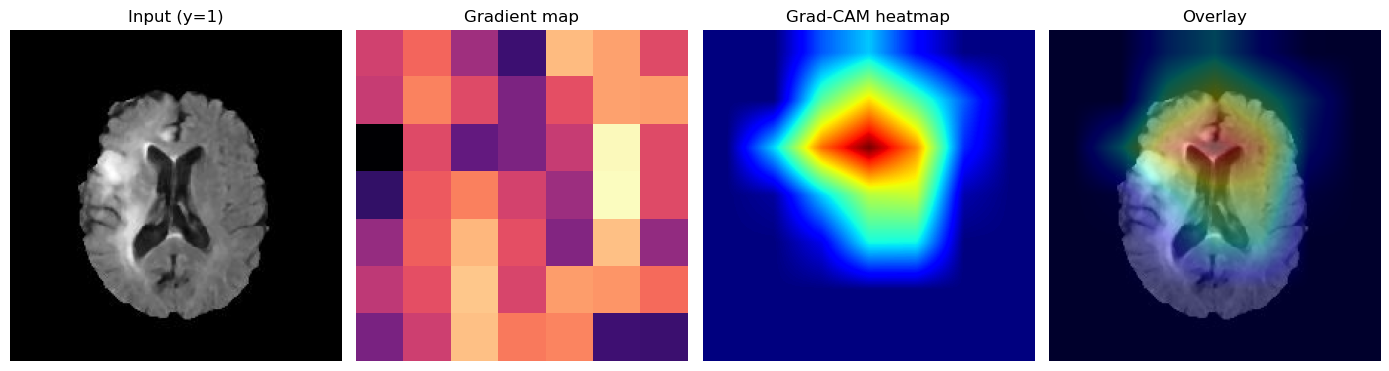

In [50]:
x_batch, y_batch = next(test_data)
img = x_batch[0:1]
true_label = int(y_batch[0])

prob, grad_map, heatmap, overlay = gradcam_binary_densenet_connected(base, head_layers, img)

print("True label:", true_label, "| Pred prob(tumor):", prob)

plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.title(f"Input (y={true_label})"); plt.imshow(img[0]); plt.axis("off")
plt.subplot(1,4,2); plt.title("Gradient map"); plt.imshow(grad_map, cmap="magma"); plt.axis("off")
plt.subplot(1,4,3); plt.title("Grad-CAM heatmap"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()

True label: 1 | Pred prob(tumor): 0.42371198534965515


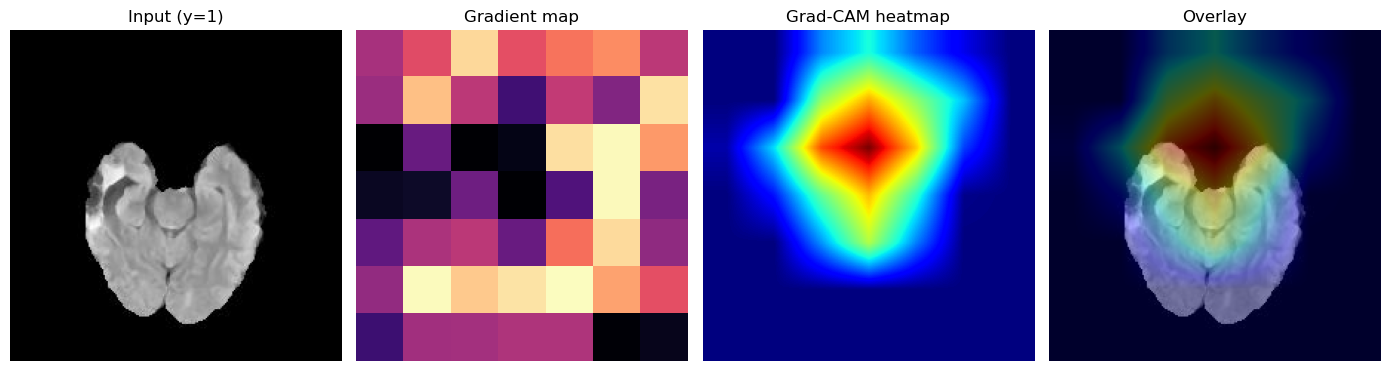

In [52]:
x_batch, y_batch = next(test_data)
img = x_batch[0:1]
true_label = int(y_batch[0])

prob, grad_map, heatmap, overlay = gradcam_binary_densenet_connected(base, head_layers, img)

print("True label:", true_label, "| Pred prob(tumor):", prob)

plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.title(f"Input (y={true_label})"); plt.imshow(img[0]); plt.axis("off")
plt.subplot(1,4,2); plt.title("Gradient map"); plt.imshow(grad_map, cmap="magma"); plt.axis("off")
plt.subplot(1,4,3); plt.title("Grad-CAM heatmap"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()

True label: 0 | Pred prob(tumor): 0.46379318833351135


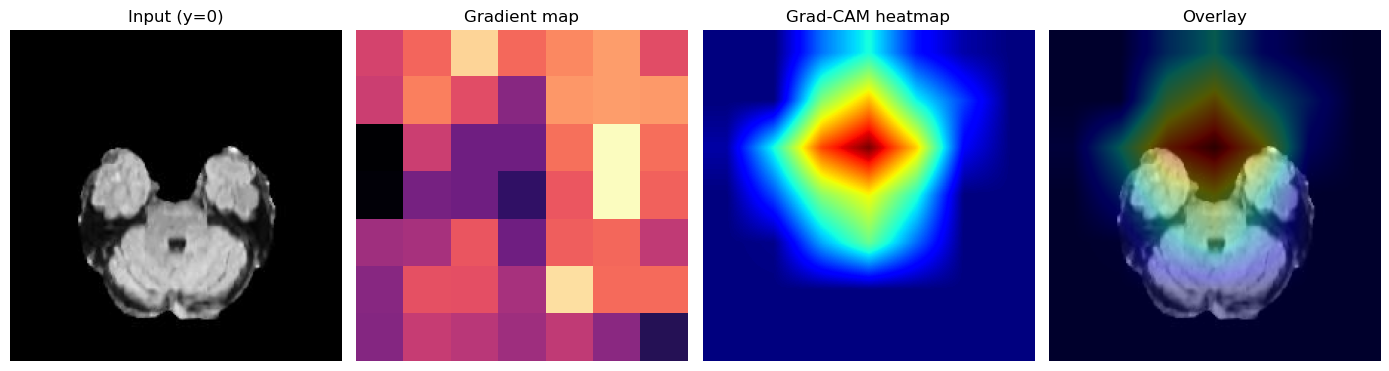

In [54]:
x_batch, y_batch = next(test_data)
img = x_batch[0:1]
true_label = int(y_batch[0])

prob, grad_map, heatmap, overlay = gradcam_binary_densenet_connected(base, head_layers, img)

print("True label:", true_label, "| Pred prob(tumor):", prob)

plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.title(f"Input (y={true_label})"); plt.imshow(img[0]); plt.axis("off")
plt.subplot(1,4,2); plt.title("Gradient map"); plt.imshow(grad_map, cmap="magma"); plt.axis("off")
plt.subplot(1,4,3); plt.title("Grad-CAM heatmap"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout(); plt.show()

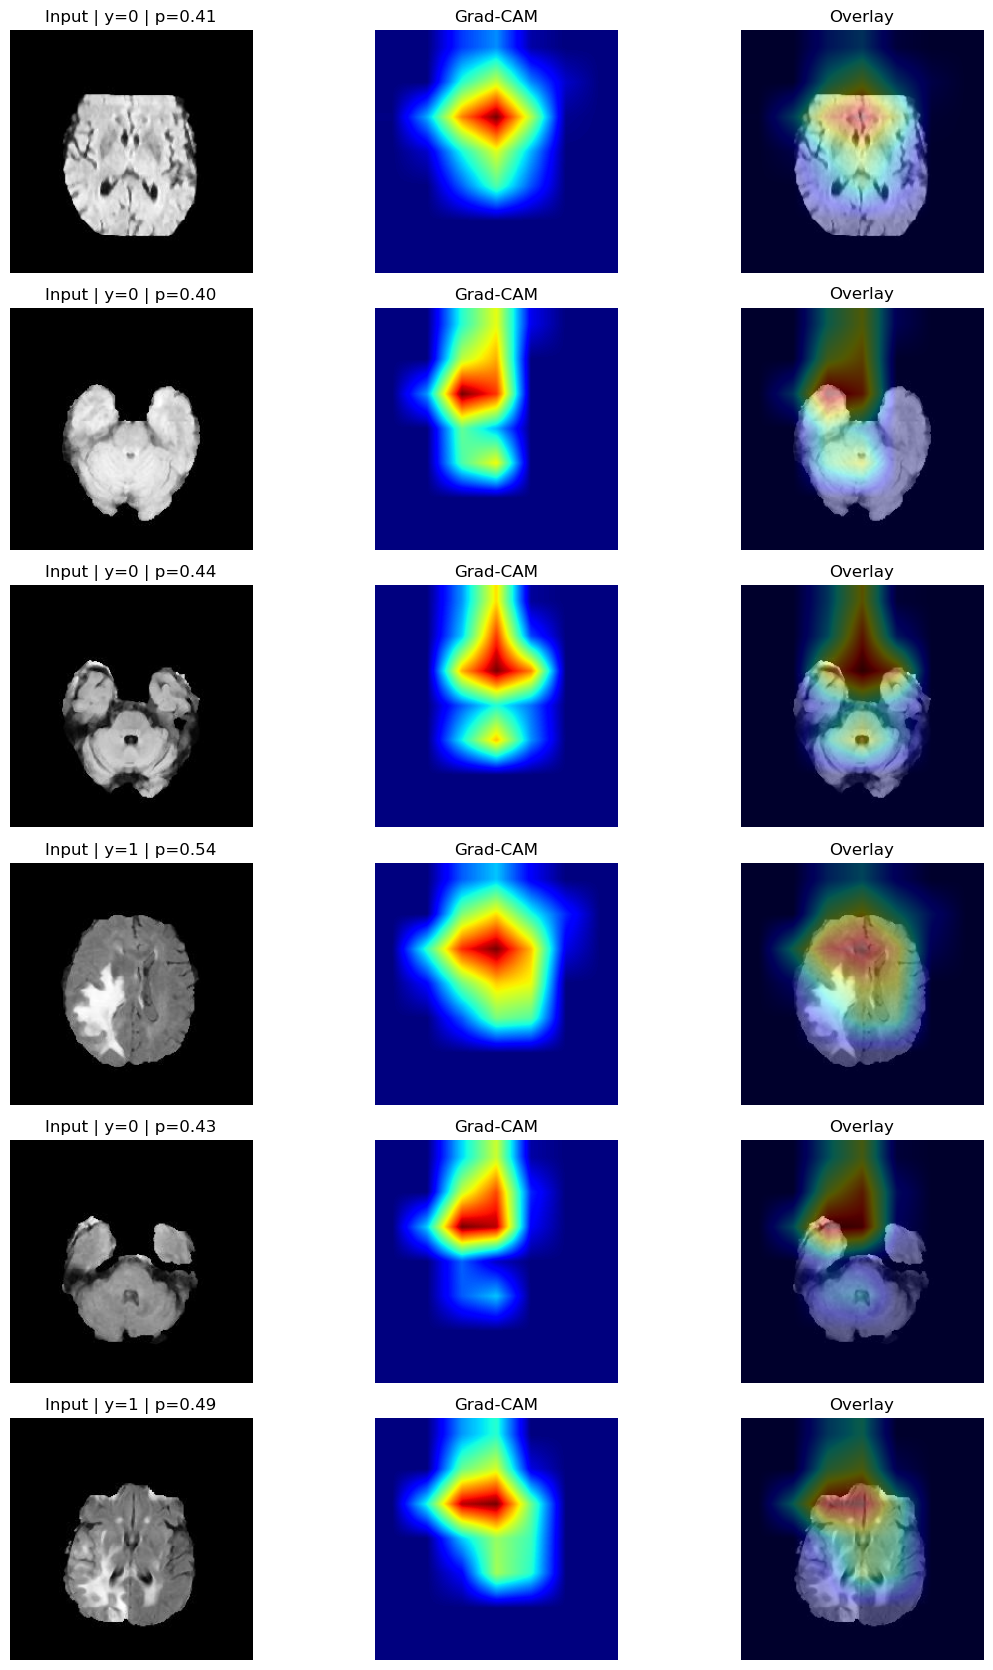

In [22]:
def show_n_overlays(n=6):
    x_batch, y_batch = next(test_data)
    n = min(n, len(x_batch))

    plt.figure(figsize=(12, 2.8*n))
    for i in range(n):
        img = x_batch[i:i+1]
        true_label = int(y_batch[i])

        prob, _, heatmap, overlay = gradcam_binary_densenet_connected(base, head_layers, img)

        plt.subplot(n, 3, 3*i+1)
        plt.imshow(img[0]); plt.axis("off")
        plt.title(f"Input | y={true_label} | p={prob:.2f}")

        plt.subplot(n, 3, 3*i+2)
        plt.imshow(heatmap, cmap="jet"); plt.axis("off")
        plt.title("Grad-CAM")

        plt.subplot(n, 3, 3*i+3)
        plt.imshow(overlay); plt.axis("off")
        plt.title("Overlay")

    plt.tight_layout()
    plt.show()

show_n_overlays(6)


conv5_block16_2_conv prob= 0.48220962285995483


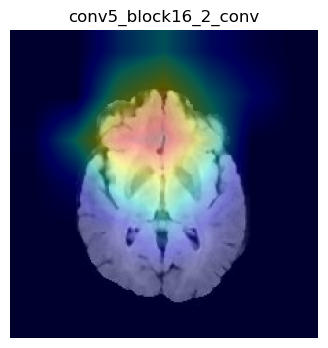

conv4_block24_2_conv prob= 0.48220962285995483


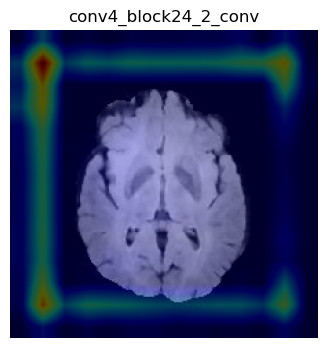

conv3_block12_2_conv prob= 0.48220962285995483


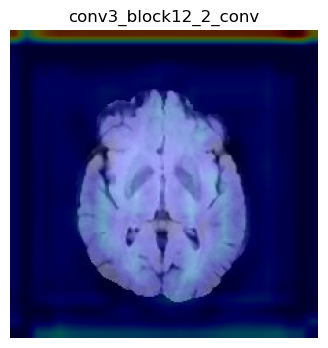

In [23]:
for L in ["conv5_block16_2_conv", "conv4_block24_2_conv", "conv3_block12_2_conv"]:
    prob, _, _, overlay = gradcam_binary_densenet_connected(base, head_layers, img, last_conv_layer_name=L)
    print(L, "prob=", prob)
    plt.figure(figsize=(4,4))
    plt.imshow(overlay); plt.axis("off"); plt.title(L)
    plt.show()